In [2]:
import numpy as np
import os
import time
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten

from imagenet_utils import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

/Users/hardika/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/hardika/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
PATH = os.getcwd()

In [4]:
data_path = PATH + '/FULL_FACE_TRAIN'

In [5]:
data_dir_list = os.listdir(data_path)

In [6]:
img_data_list=[]

In [7]:
for dataset in data_dir_list:
	img_list=os.listdir(data_path+'/'+ dataset)
	print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
	for img in img_list:
		img_path = data_path + '/'+ dataset + '/'+ img
		img = image.load_img(img_path, target_size=(224, 224))
		x = image.img_to_array(img)
		x = np.expand_dims(x, axis=0)
		x = preprocess_input(x)
#		x = x/255
		#print('Input image shape:', x.shape)
		img_data_list.append(x)   

Loaded the images of dataset-Surprise face cropped

Loaded the images of dataset-Disgust face cropped

Loaded the images of dataset-Happy face cropped

Loaded the images of dataset-Contempt face cropped

Loaded the images of dataset-Angry face cropped

Loaded the images of dataset-Sad face cropped

Loaded the images of dataset-Fear face cropped



In [8]:
img_data = np.array(img_data_list) # takes time"
        
        # To bring data in the form (no. of images, row, col, channels)
        #print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
img_data=img_data[0]
       # print (img_data.shape) 

In [9]:
num_classes = 7
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

In [10]:
labels[0:540]=0
labels[540:880]=1
labels[880:1495]=2
labels[1495:1611]=3
labels[1611:2043]=4
labels[2043:2363]=5
labels[2363:2600]=6

In [10]:
names = ['Surprised face','Sad face','Happy face','Fear face','Disgust face','Contempt face','Angry face']

In [11]:
Y = np_utils.to_categorical(labels, num_classes)

In [12]:
x,y = shuffle(img_data,Y, random_state=2) # TAKES TIME 
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2) 

In [26]:
image_input = Input(shape=(224, 224, 3))

model = ResNet50(input_tensor=image_input, include_top=True,weights='imagenet')
model.summary()
last_layer = model.get_layer('avg_pool').output
x= Flatten(name='flatten')(last_layer)
out = Dense(num_classes, activation='softmax', name='output_layer')(x)
custom_resnet_model = Model(inputs=image_input,outputs= out)
custom_resnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [14]:
for layer in custom_resnet_model.layers[:-1]: 
	layer.trainable = False

custom_resnet_model.layers[-1].trainable

True

In [15]:
custom_resnet_model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [16]:
t=time.time()
hist = custom_resnet_model.fit(X_train, y_train, batch_size=32, epochs=25, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))

Train on 1820 samples, validate on 780 samples
Epoch 1/25
1820/1820 [==============================] - 626s 344ms/step - loss: 1.1700 - acc: 0.6016 - val_loss: 2.1500 - val_acc: 0.3167
Epoch 2/25
1820/1820 [==============================] - 737s 405ms/step - loss: 0.6171 - acc: 0.8060 - val_loss: 3.5566 - val_acc: 0.1346
Epoch 3/25
1820/1820 [==============================] - 645s 354ms/step - loss: 0.4359 - acc: 0.8709 - val_loss: 2.7831 - val_acc: 0.2615
Epoch 4/25
1820/1820 [==============================] - 678s 373ms/step - loss: 0.3265 - acc: 0.9187 - val_loss: 2.1306 - val_acc: 0.3897
Epoch 5/25
1820/1820 [==============================] - 695s 382ms/step - loss: 0.2579 - acc: 0.9456 - val_loss: 2.5159 - val_acc: 0.2359
Epoch 6/25
1820/1820 [==============================] - 679s 373ms/step - loss: 0.2068 - acc: 0.9522 - val_loss: 2.3802 - val_acc: 0.3154
Epoch 7/25
1820/1820 [==============================] - 675s 371ms/step - loss: 0.1698 - acc: 0.9676 - val_loss: 2.8159 - val

In [17]:
(loss, accuracy) = custom_resnet_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

780/780 [==============================] - 245s 314ms/step


In [18]:
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))


[INFO] loss=2.5009, accuracy: 37.5641%


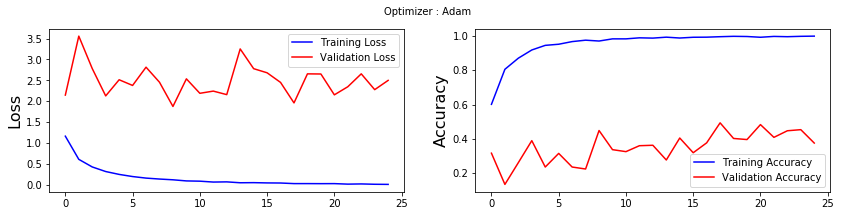

In [27]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], 'b', label='Training Loss')
plt.plot(hist.history['val_loss'], 'r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], 'b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], 'r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [19]:
from sklearn.metrics import classification_report,confusion_matrix
import itertools

In [20]:
Y_pred = custom_resnet_model.predict(X_test)

In [21]:
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)


[2 3 2 3 3 2 5 5 3 2 3 3 3 2 6 3 6 3 3 2 3 6 3 2 3 3 3 3 3 3 6 3 0 2 3 3 2
 6 3 2 0 3 6 3 3 3 3 2 2 5 3 5 0 5 3 0 3 3 2 3 3 3 3 2 2 3 3 3 6 3 3 3 0 2
 0 3 2 2 3 5 3 3 2 2 0 5 5 5 3 5 3 2 2 6 0 3 2 4 6 3 2 3 5 3 0 3 3 2 3 3 5
 3 3 2 3 3 0 3 6 3 6 0 0 3 3 5 3 5 0 2 0 0 5 2 3 3 2 2 2 1 6 0 3 3 3 2 6 3
 2 2 3 3 0 0 3 2 3 3 2 2 0 3 3 2 2 2 2 3 2 2 3 6 2 2 3 3 2 3 3 2 3 3 3 5 6
 3 3 3 3 3 3 3 3 3 2 2 0 0 3 2 5 3 3 3 3 5 2 2 3 0 3 3 3 6 0 3 3 3 5 0 3 3
 3 3 3 3 2 3 2 3 3 0 3 2 3 2 2 0 3 3 0 3 3 3 5 3 3 3 3 0 3 3 5 2 2 0 5 0 6
 3 3 3 3 2 2 3 2 3 3 3 3 6 5 3 3 6 3 3 6 2 3 2 3 3 3 0 3 3 3 3 3 2 0 1 3 2
 6 5 3 2 2 3 6 2 3 0 3 6 2 6 3 0 2 3 3 3 3 0 3 3 3 2 3 3 3 0 3 2 3 3 3 5 2
 3 3 0 5 3 3 3 3 3 3 5 0 4 3 3 3 3 0 2 2 2 5 0 2 0 2 6 2 2 3 3 3 0 5 3 3 0
 3 3 3 2 5 5 3 3 2 2 2 2 3 3 3 3 2 3 3 2 3 3 3 3 6 2 0 3 2 5 2 2 3 3 3 3 2
 3 3 5 3 2 3 3 3 3 3 2 4 3 3 5 3 5 3 2 3 6 2 3 3 3 5 3 2 2 2 0 3 2 3 5 3 3
 6 3 3 4 3 3 2 2 3 3 3 3 5 6 3 0 3 0 0 3 3 5 3 3 3 3 2 6 3 3 0 3 3 0 3 3 6
 2 3 2 3 3 3 5 2 0 2 3 2 

In [22]:
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=names))

                precision    recall  f1-score   support

Surprised face       1.00      0.55      0.71       157
      Sad face       0.50      0.01      0.02        96
    Happy face       0.66      0.62      0.64       192
     Fear face       0.08      1.00      0.16        33
  Disgust face       1.00      0.05      0.09       122
 Contempt face       0.43      0.24      0.31       113
    Angry face       0.40      0.31      0.35        67

   avg / total       0.68      0.38      0.40       780



In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
       # cm=round(cm,3)
        
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 86   0   0  42   0  12  17]
 [  0   1  26  55   0   9   5]
 [  0   0 119  68   0   0   5]
 [  0   0   0  33   0   0   0]
 [  0   1  23  75   6  15   2]
 [  0   0   8  76   0  27   2]
 [  0   0   5  41   0   0  21]]


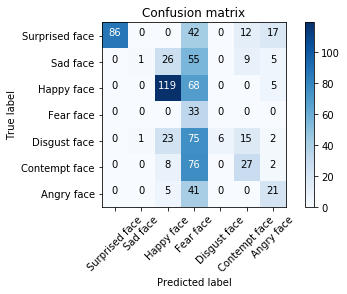

In [24]:
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))
plot_confusion_matrix(cnf_matrix, classes=names, normalize=False,title='Confusion matrix')
#plt.figure()
plt.show()

# STORING THE WEIGHTS
fname="Weights-Full_Face_7class_25_epochs_vgg16.hdf5"
custom_resnet_model.save_weights(fname,overwrite=True)


#  LOADING WEIGHTS
fname= "Weights-Full_Face_7class_25_epochs_vgg16.hdf5"
custom_resnet_model.load_weights(fname)
        